In [1]:
import numpy as np
from torch.utils.data import DataLoader
from stl import mesh
from torch.utils.data import Dataset
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from ordered_set import OrderedSet
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device='cpu'
torch.manual_seed(0)


/home/cyberguli/.conda/envs/sissa/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/cyberguli/.conda/envs/sissa/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
def getinfo(stl):
    your_mesh = mesh.Mesh.from_file(stl)
    myList = list(OrderedSet(tuple(map(tuple,your_mesh.vectors.reshape(36,3)))))
    array=your_mesh.vectors
    K=len(your_mesh)
    topo=np.zeros((12,3))
    for i in range(12):
        for j in range(3):
            topo[i,j]=myList.index(tuple(array[i,j].tolist()))
    N=9*K
    return torch.tensor(array.copy()),torch.tensor(myList),N,len(myList)*3,torch.tensor(topo, dtype=torch.int64)
    
def applytopology(V,M):
    Q=torch.zeros((M.shape[0],3,3),device=device)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            Q[i,j]=V[M[i,j].item()]
    return Q

In [3]:
data=[]
M=0
N=0
K=0
for i in range(1,1000):
    meshs,points,N,K,M=getinfo("parallelepiped_{}.stl".format(i))
    if device!='cpu':
        meshs=meshs.to(device)
    data.append(meshs)

if device!='cpu':
    M=M.to(device)

In [4]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, K)
        self.softplus = nn.Softplus()
        self.tanh = nn.Tanh()

    def forward(self, z):
        temp=self.fc4(self.fc3(self.fc2(self.fc1(z))))
        result=applytopology(temp.reshape((int(K//3),3)),M)
        return result

class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(N,hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        self.fc32 = nn.Sigmoid()
        self.Normal = torch.distributions.Normal(0, 1)
        if device!='cpu':
            self.Normal.loc = self.Normal.loc.cuda() 
            self.Normal.scale = self.Normal.scale.cuda()
        self.kl = 0



    def forward(self, x):
        x=x.reshape(N)
        hidden=self.fc1(x)
        mu=self.fc21(hidden)
        sigma=torch.exp(self.fc32(self.fc22(hidden)))
        z = mu + sigma*self.Normal.sample(mu.shape)
        self.kl = ((sigma**2 + mu**2)/2 - torch.log(sigma) - 1/2).sum()
        return z

        
class VAE(nn.Module):
    def __init__(self, z_dim=2, hidden_dim=30, use_cuda=False):
        super().__init__()
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        self.z_dim = z_dim
        

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


def train(vae, data,epochs=500):
    error=[]
    opt = torch.optim.Adam(vae.parameters(),lr=0.000001)
    for epoch in range(epochs):
        if epoch%100==0:
            print(epoch)
        
        for x in data:
            opt.zero_grad()
            x_hat = vae(x)
            loss = 1/(2*K*len(data))*((x - x_hat)**2).sum() + vae.encoder.kl
            loss.backward()
            opt.step()
        error.append(loss.clone().detach().item())
    return vae,error






0
100
200
300
400


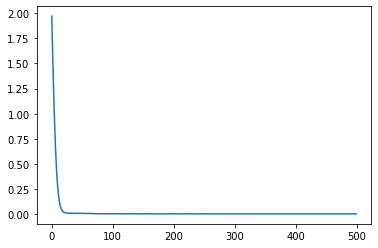

In [5]:
vae = VAE().to(device) # GPU
#vae.load_state_dict(torch.load("cube.pt"))
vae,error = train(vae, data)
plt.plot([i for i in range(len(error))],error)

In [6]:
ztest=torch.distributions.Normal(0, 1).sample([2]).to(device)
h=vae.decoder(ztest).to('cpu').detach().numpy()
cube = mesh.Mesh(np.zeros(12, dtype=mesh.Mesh.dtype))
cube.vectors=h
cube.save('test.stl')
cube= mesh.Mesh.from_file('test.stl')


In [8]:
torch.save(vae.state_dict(), 'parallelepiped.plt')
